In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tqdm import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import glob
import warnings
warnings.filterwarnings('ignore')

In [3]:
image_data='/kaggle/input/brain-mri-scan-images-tumor-detection/brain_mri_scan_images'
pd.DataFrame(os.listdir(image_data),columns=['Files_Name'])

,Files_Name
0,negative
1,positive


In [6]:
files=[i for i in glob.glob(image_data+"//*//*")]
np.random.shuffle(files)
labels=[os.path.dirname(i).split("/")[-1] for i in files]
data=zip(files,labels)
dataframe=pd.DataFrame(data,columns=['Images','Label'])
dataframe

,Images,Label
0,/kaggle/input/brain-mri-scan-images-tumor-dete...,negative
1,/kaggle/input/brain-mri-scan-images-tumor-dete...,negative
2,/kaggle/input/brain-mri-scan-images-tumor-dete...,negative
3,/kaggle/input/brain-mri-scan-images-tumor-dete...,negative
4,/kaggle/input/brain-mri-scan-images-tumor-dete...,positive
...,...,...
222,/kaggle/input/brain-mri-scan-images-tumor-dete...,positive
223,/kaggle/input/brain-mri-scan-images-tumor-dete...,negative
224,/kaggle/input/brain-mri-scan-images-tumor-dete...,negative
225,/kaggle/input/brain-mri-scan-images-tumor-dete...,positive


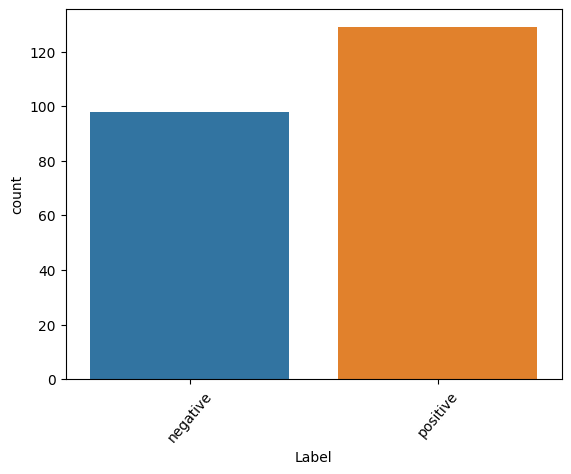

In [9]:
sns.countplot(x=dataframe['Label'])
plt.xticks(rotation=50);

In [10]:
train_data_dir=image_data
batch_size=32
target_size=(224,224)
validation_split=0.2
train=tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)
validation=tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)

Found 227 files belonging to 2 classes.
Using 182 files for training.
Found 227 files belonging to 2 classes.
Using 45 files for validation.


In [11]:
class_names=train.class_names
class_names

['negative', 'positive']

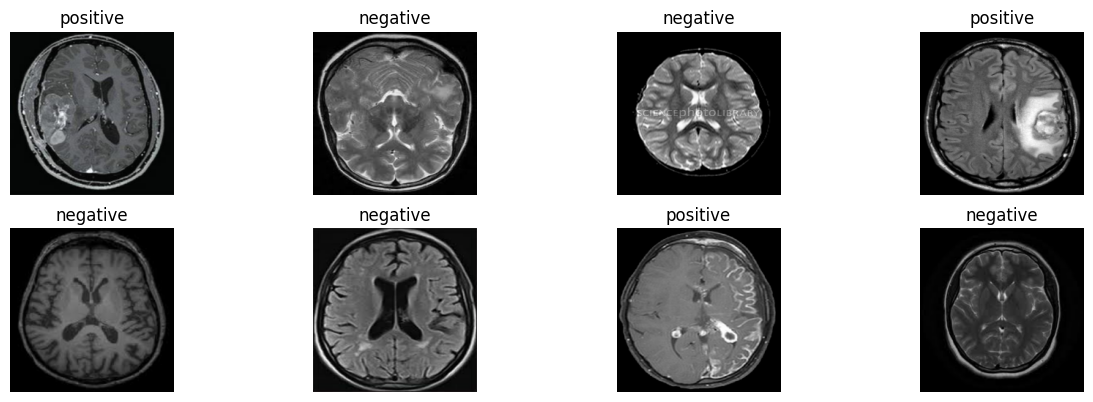

In [12]:
plt.figure(figsize=(15,20))
for images,labels in train.take(1):
    for i in range(8):
        ax=plt.subplot(8,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [15]:
base_model=tf.keras.applications.EfficientNetB0(input_shape=(224,224,3),
                                               include_top=False,weights='imagenet')
base_model.trainable=False
keras_model=keras.models.Sequential()
keras_model.add(base_model)
keras_model.add(keras.layers.Flatten())
keras_model.add(keras.layers.Dropout(0.5))
keras_model.add(keras.layers.Dense(10,activation=tf.nn.softmax))
keras_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dropout (Dropout)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 10)                627210    
                                                                 
Total params: 4,676,781
Trainable params: 627,210
Non-trainable params: 4,049,571
_________________________________________________________________


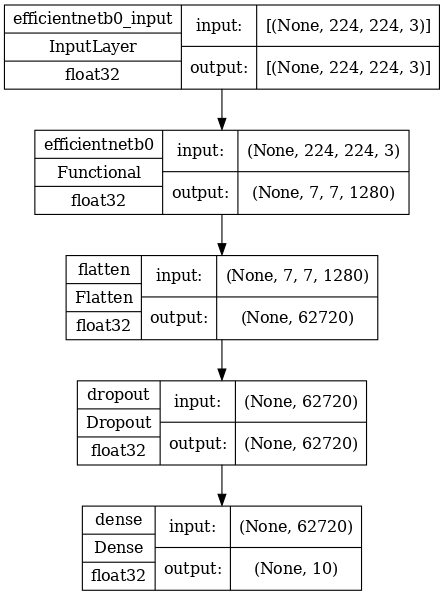

In [17]:
tf.keras.utils.plot_model(keras_model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=80)

In [23]:
checkpoint =ModelCheckpoint("my_keras_model.h5", save_best_only=True)

In [24]:
early_stopping =EarlyStopping(patience=5, restore_best_weights=True)

In [41]:
keras_model.compile(optimizer ='Adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist=keras_model.fit_generator(train,epochs=20,validation_data=validation)

Epoch 1/20


2023-11-02 06:07:16.594953: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


6/6 [==============================] - 10s 433ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 9.5367e-08 - val_accuracy: 1.0000
Epoch 2/20
6/6 [==============================] - 1s 71ms/step - loss: 0.0233 - accuracy: 0.9945 - val_loss: 4.3975e-07 - val_accuracy: 1.0000
Epoch 3/20
6/6 [==============================] - 1s 73ms/step - loss: 0.0223 - accuracy: 0.9945 - val_loss: 3.5233e-07 - val_accuracy: 1.0000
Epoch 4/20
6/6 [==============================] - 1s 70ms/step - loss: 0.0075 - accuracy: 0.9945 - val_loss: 4.3710e-07 - val_accuracy: 1.0000
Epoch 5/20
6/6 [==============================] - 1s 76ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 8.6889e-07 - val_accuracy: 1.0000
Epoch 6/20
6/6 [==============================] - 1s 83ms/step - loss: 2.1303e-04 - accuracy: 1.0000 - val_loss: 4.0230e-05 - val_accuracy: 1.0000
Epoch 7/20
6/6 [==============================] - 1s 74ms/step - loss: 0.0055 - accuracy: 0.9945 - val_loss: 8.3597e-06 - val_accuracy: 1.0000
Epoc

In [42]:
score,acc=keras_model.evaluate(validation)
print('Test Loss =',score)
print('Test Accuracy=',acc)

2/2 [==============================] - 0s 25ms/step - loss: 9.5513e-05 - accuracy: 1.0000
Test Loss = 9.551276889396831e-05
Test Accuracy= 1.0


In [46]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,0.002056,1.000000,9.536729e-08,1.000000
1,0.023346,0.994505,4.397472e-07,1.000000
2,0.022252,0.994505,3.523290e-07,1.000000
3,0.007510,0.994505,4.370974e-07,1.000000
4,0.003582,1.000000,8.688893e-07,1.000000
5,0.000213,1.000000,4.022996e-05,1.000000
6,0.005542,0.994505,8.359671e-06,1.000000
7,0.005765,0.994505,1.166958e-04,1.000000
8,0.066755,0.978022,1.298676e-01,0.977778
9,0.055803,0.983516,4.053092e-07,1.000000


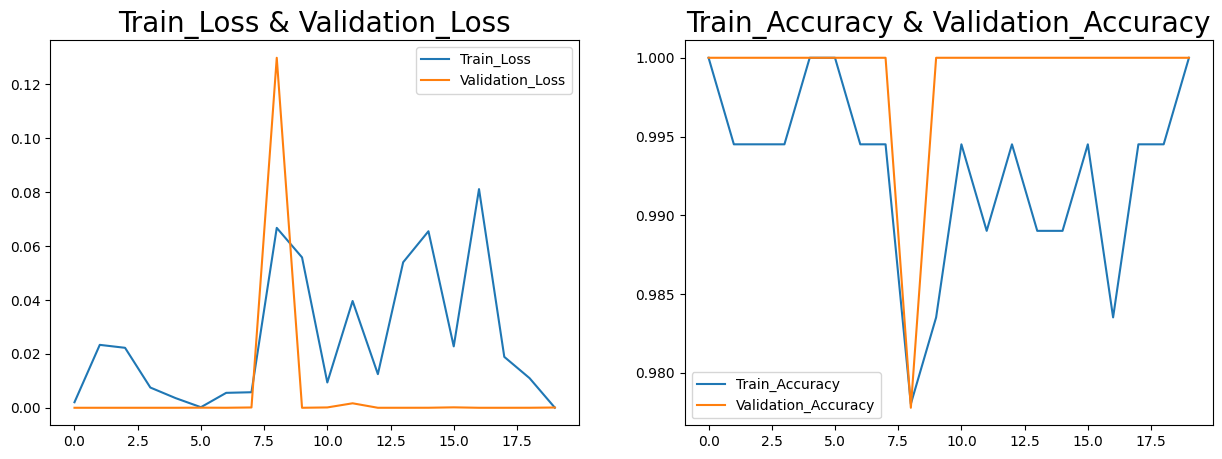

In [47]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [51]:
X_val,y_val,y_pred=[],[],[]
for images,labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
prediction=keras_model.predict(np.array(X_val))
for i in prediction:
    y_pred.append(np.argmax(i))
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df
    

2/2 [==============================] - 0s 36ms/step


,Actual,Prediction
0,0,0
1,1,1
2,1,1
3,1,1
4,1,1
5,0,0
6,0,0
7,1,1
8,1,1
9,1,1


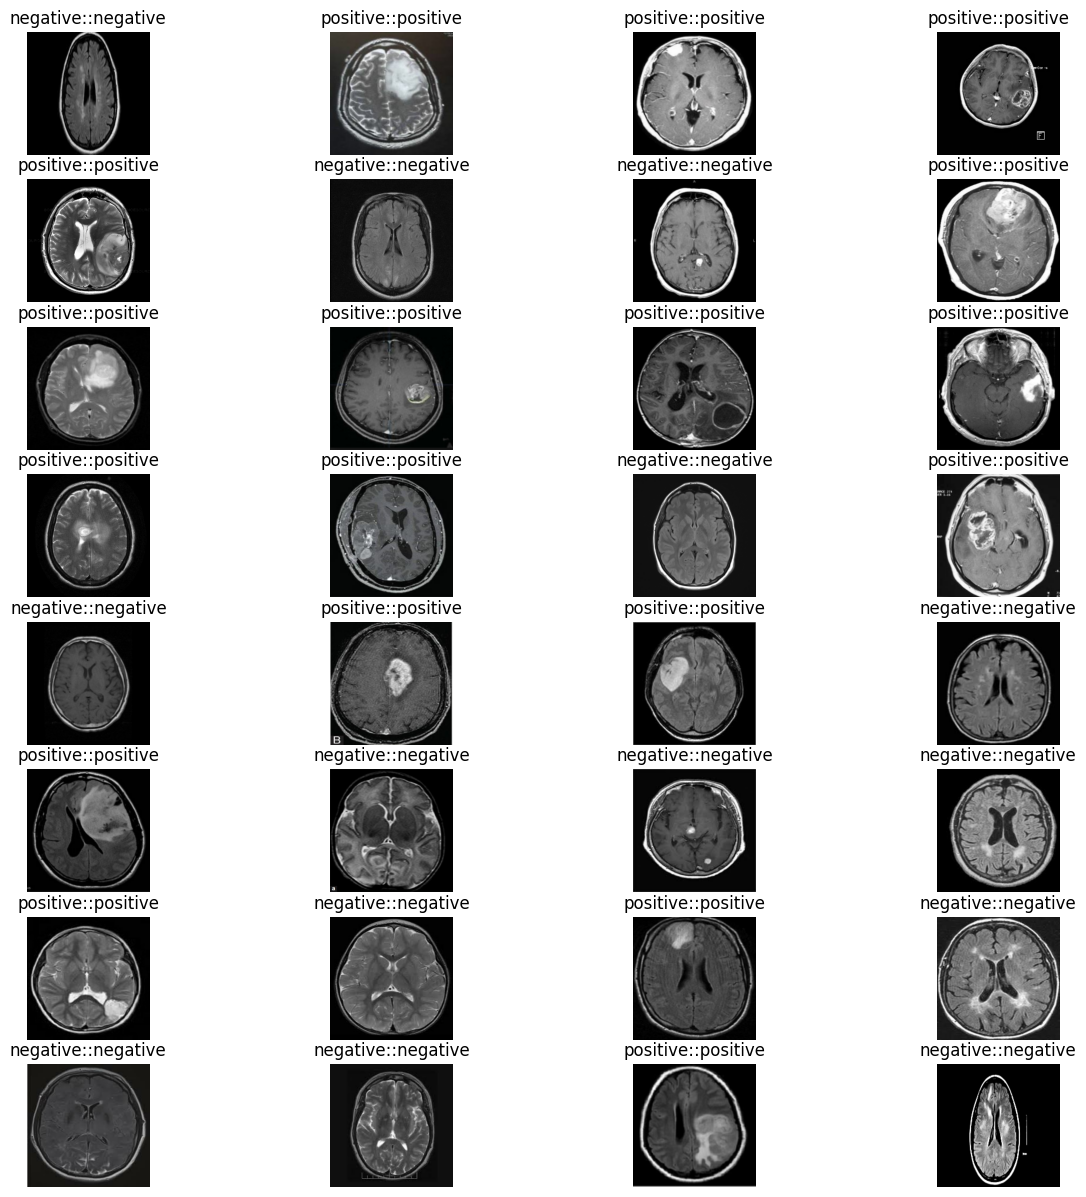

In [58]:
plt.figure(figsize=(15,15))
for i in range(32):
    ax=plt.subplot(8,4,i+1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]}::{class_names[y_pred[i]]}')
    plt.axis("off")

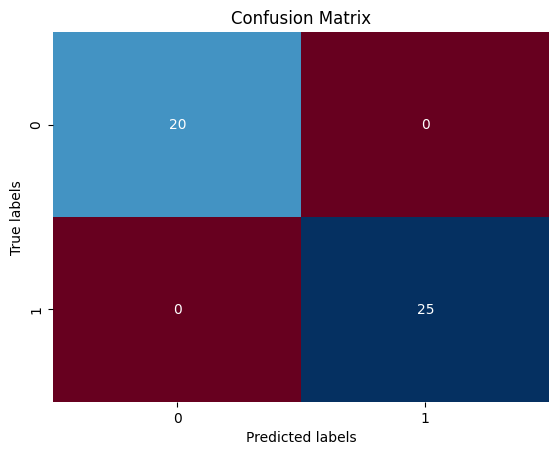

array([[20,  0],
       [ 0, 25]])

In [59]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
plt.show()
CM